In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd "/content/gdrive/My Drive/active"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/active


In [2]:
import pandas as pd
origdata = pd.read_csv("pcmdata.csv",index_col=0)
#origdata['new'] = 0
origdata[:2]

,target,bit0,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,bit9,bit10,bit11,bit12,bit13,bit14,bit15,bit16,bit17,bit18,bit19,bit20,bit22,bit23,bit24,bit25,bit26,bit27,bit28,bit29,bit30,bit31,bit32,bit33,bit34,bit35,bit36,bit37,bit38,bit39,...,dp343,dp344,dp345,dp346,dp347,dp348,dp349,dp350,dp351,dp352,dp353,dp354,dp355,dp356,dp357,dp358,dp359,dp360,dp361,dp362,dp365,dp366,dp370,dp381,dp382,dp383,dp384,dp385,dp386,dp389,dp391,dp392,dp393,dp394,dp395,dp396,dp397,dp398,class,activity
compound,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CHEMBL4216101,fipv,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,...,0.0,0.653595,0.0,0.653595,0.0,1.30719,0.0,0.980392,0.326797,1.633987,0.0,0.0,1.30719,0.653595,0.326797,0.980392,0.0,0.653595,0.326797,0.0,0.326797,0.0,0.326797,0.326797,0.0,0.0,0.980392,0.326797,1.633987,0.326797,0.326797,0.326797,0.0,0.0,0.0,0.326797,0.0,0.326797,1,5.17
CHEMBL4212620,fipv,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,...,0.0,0.653595,0.0,0.653595,0.0,1.30719,0.0,0.980392,0.326797,1.633987,0.0,0.0,1.30719,0.653595,0.326797,0.980392,0.0,0.653595,0.326797,0.0,0.326797,0.0,0.326797,0.326797,0.0,0.0,0.980392,0.326797,1.633987,0.326797,0.326797,0.326797,0.0,0.0,0.0,0.326797,0.0,0.326797,1,5.26


In [3]:
#del origdata['new'] 
#del origdata['activity']
del origdata['target'] 
del origdata['class']
origdata[:2]

,bit0,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,bit9,bit10,bit11,bit12,bit13,bit14,bit15,bit16,bit17,bit18,bit19,bit20,bit22,bit23,bit24,bit25,bit26,bit27,bit28,bit29,bit30,bit31,bit32,bit33,bit34,bit35,bit36,bit37,bit38,bit39,bit40,...,dp342,dp343,dp344,dp345,dp346,dp347,dp348,dp349,dp350,dp351,dp352,dp353,dp354,dp355,dp356,dp357,dp358,dp359,dp360,dp361,dp362,dp365,dp366,dp370,dp381,dp382,dp383,dp384,dp385,dp386,dp389,dp391,dp392,dp393,dp394,dp395,dp396,dp397,dp398,activity
compound,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CHEMBL4216101,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,...,0.0,0.0,0.653595,0.0,0.653595,0.0,1.30719,0.0,0.980392,0.326797,1.633987,0.0,0.0,1.30719,0.653595,0.326797,0.980392,0.0,0.653595,0.326797,0.0,0.326797,0.0,0.326797,0.326797,0.0,0.0,0.980392,0.326797,1.633987,0.326797,0.326797,0.326797,0.0,0.0,0.0,0.326797,0.0,0.326797,5.17
CHEMBL4212620,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,...,0.0,0.0,0.653595,0.0,0.653595,0.0,1.30719,0.0,0.980392,0.326797,1.633987,0.0,0.0,1.30719,0.653595,0.326797,0.980392,0.0,0.653595,0.326797,0.0,0.326797,0.0,0.326797,0.326797,0.0,0.0,0.980392,0.326797,1.633987,0.326797,0.326797,0.326797,0.0,0.0,0.0,0.326797,0.0,0.326797,5.26


In [4]:
%cd "master/"

/content/gdrive/My Drive/active/master


In [5]:
data = origdata.values
X = data[:,:-1]
y = data[:,-1]

In [6]:
from sklearn import preprocessing
normalizer = preprocessing.Normalizer().fit(X)
X = normalizer.transform(X)

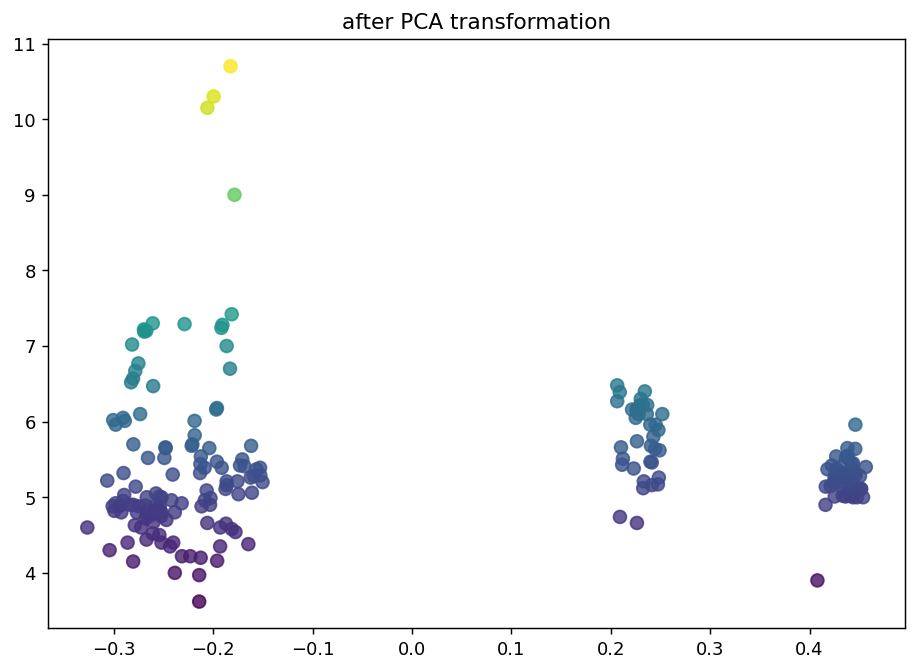

In [7]:
from sklearn.decomposition import PCA
# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=1)
transformed = pca.fit_transform(X=X)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Isolate the data we'll need for plotting.
x_component = transformed[:, 0]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(8.5, 6), dpi=130)
plt.scatter(x=x_component, y=y, c=y, cmap='viridis', s=50, alpha=8/10)
plt.title('after PCA transformation')
plt.show()

In [14]:
from modAL.models import BayesianOptimizer
from modAL.acquisition import max_EI
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
import numpy as np

n_initial = 120
initial_idx = np.random.choice(range(len(X)), size=n_initial, replace=False)
X_initial, y_initial = X[initial_idx], y[initial_idx]


kernel = Matern(length_scale=1.0)
regressor = GaussianProcessRegressor(kernel=kernel)

optimizer = BayesianOptimizer(
    estimator=regressor,
    X_training=X_initial, y_training=y_initial,
    query_strategy=max_EI
)

performance_history=[]
# Bayesian optimization
for n_query in range(75):
    query_idx, query_inst = optimizer.query(X)
    optimizer.teach(X[query_idx].reshape(1, -1), y[query_idx].reshape(1,))
    model_accuracy = optimizer.score(X, y)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=n_query + 1, acc=model_accuracy))
    performance_history.append(model_accuracy)

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std


Accuracy after query 1: 0.7146


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std


Accuracy after query 2: 0.8129


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std


Accuracy after query 3: 0.8370
Accuracy after query 4: 0.8442


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: Run

Accuracy after query 5: 0.8461


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std


Accuracy after query 6: 0.8800


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std


Accuracy after query 7: 0.8793
Accuracy after query 8: 0.8794


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std


Accuracy after query 9: 0.8793


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: Run

Accuracy after query 10: 0.8801
Accuracy after query 11: 0.8794


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: Run

Accuracy after query 12: 0.8808
Accuracy after query 13: 0.8817


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: Run

Accuracy after query 14: 0.8825


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std


Accuracy after query 15: 0.8744
Accuracy after query 16: 0.8828


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: Run

Accuracy after query 17: 0.8818
Accuracy after query 18: 0.8829


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: Run

Accuracy after query 19: 0.8832
Accuracy after query 20: 0.8864


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std


Accuracy after query 21: 0.8864


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std


Accuracy after query 22: 0.8866


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: Run

Accuracy after query 23: 0.8865
Accuracy after query 24: 0.8866


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std


Accuracy after query 25: 0.8865


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std


Accuracy after query 26: 0.8864


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std


Accuracy after query 27: 0.8865


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std


Accuracy after query 28: 0.8847


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: Run

Accuracy after query 29: 0.8895
Accuracy after query 30: 0.8888


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std


Accuracy after query 31: 0.8892
Accuracy after query 32: 0.8891


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: Run

Accuracy after query 33: 0.8892
Accuracy after query 34: 0.8889


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std


Accuracy after query 35: 0.8887


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std


Accuracy after query 36: 0.8889


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std


Accuracy after query 37: 0.8896


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std


Accuracy after query 38: 0.8895


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std


Accuracy after query 39: 0.8896


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std


Accuracy after query 40: 0.8895


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: Run

Accuracy after query 41: 0.8941
Accuracy after query 42: 0.8934


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std


Accuracy after query 43: 0.8939


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std


Accuracy after query 44: 0.8955


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std


Accuracy after query 45: 0.8961
Accuracy after query 46: 0.8960


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std


Accuracy after query 47: 0.8945


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: Run

Accuracy after query 48: 0.8954


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std


Accuracy after query 49: 0.8960


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std


Accuracy after query 50: 0.8960
Accuracy after query 51: 0.8958


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std


Accuracy after query 52: 0.8960
Accuracy after query 53: 0.8955


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: Run

Accuracy after query 54: 0.8960
Accuracy after query 55: 0.8962


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std


Accuracy after query 56: 0.8956
Accuracy after query 57: 0.8963


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: Run

Accuracy after query 58: 0.8963
Accuracy after query 59: 0.8951


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: Run

Accuracy after query 60: 0.8942


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std


Accuracy after query 61: 0.8956
Accuracy after query 62: 0.8956


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std


Accuracy after query 63: 0.8956
Accuracy after query 64: 0.8947


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: Run

Accuracy after query 65: 0.8956


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std


Accuracy after query 66: 0.9031
Accuracy after query 67: 0.9027


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std


Accuracy after query 68: 0.9004


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std


Accuracy after query 69: 0.9094


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: Run

Accuracy after query 70: 0.9077


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std


Accuracy after query 71: 0.9082
Accuracy after query 72: 0.9088


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: Run

Accuracy after query 73: 0.9080


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/content/gdrive/My Drive/active/master/modAL/acquisition.py:21: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - max_val - tradeoff) / std


Accuracy after query 74: 0.9088
Accuracy after query 75: 0.9103


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [15]:
y_pred, y_std = optimizer.predict(X, return_std=True)
y_pred, y_std = y_pred.ravel(), y_std.ravel()
X_max, y_max = optimizer.get_max()


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [16]:
pca = PCA(n_components=1)
transformed = pca.fit_transform(X=optimizer.X_training)
x_component2 = transformed[:, 0]

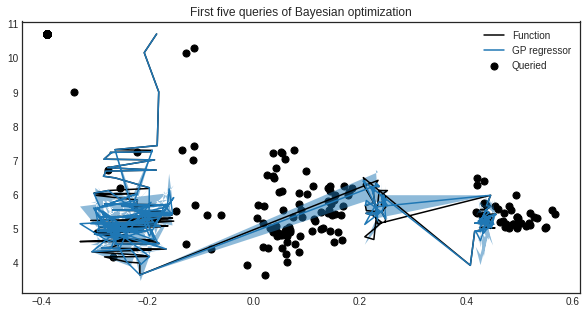

In [17]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.scatter(x_component2, optimizer.y_training, c='k', s=50, label='Queried')
    #plt.scatter(X_max, y_max, s=100, c='r', label='Current optimum')
    plt.plot(x_component, y, c='k',  label='Function')
    plt.plot(x_component, y_pred, label='GP regressor')
    plt.fill_between(x_component, y_pred - y_std, y_pred + y_std, alpha=0.5)
    plt.title('First five queries of Bayesian optimization')
    plt.legend()
    plt.show()

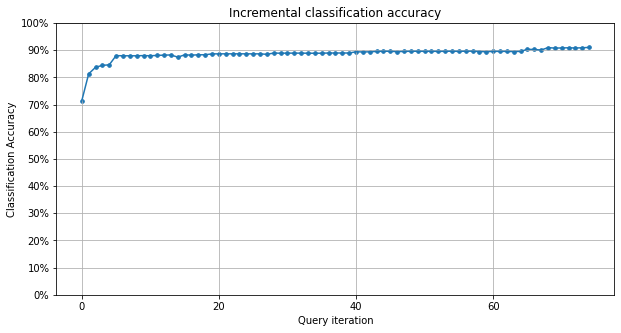

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()